In [1]:
import numpy as np
import torch
from vectorhash_imported import *
from vectorhash_convered import *
from nd_scaffold import GridScaffold as GS
import math
from scipy.stats import norm
from matrix_initializers import ConstantInitializer, SparseMatrixByScalingInitializer



lambdas = [3, 4, 5]
Ng = sum([i**2 for i in lambdas])


percent_nonzero_relu=0.01
W_gh_var=1.0
sparse_initialization=0.1
T=0.01
W_hg_std = math.sqrt(W_gh_var)
W_hg_mean = (
    -W_hg_std * norm.ppf(1 - percent_nonzero_relu) / math.sqrt(len(lambdas))
)
h_normal_mean = len(lambdas) * W_hg_mean
h_normal_std = math.sqrt(len(lambdas)) * W_hg_std
relu_theta = 0

# SparseMatrixByScalingInitializer(mean=W_hg_mean, scale=W_hg_std, device="cpu")

gs = GS(
    shapes= [(3, 3), (4, 4), (5, 5)],
    N_h= 400,
    input_size= 2000,
    h_normal_mean=h_normal_mean,
    h_normal_std=h_normal_std,
    device=None,
    sparse_matrix_initializer=SparseMatrixBySparsityInitializer(sparsity=0.6, device="cpu"),
    relu_theta=0.5,
    from_checkpoint=False,
    T=1,
    continualupdate=True,
    ratshift=False,
    initialize_W_gh_with_zeroes=False,
    pseudo_inverse=False,
    batch_update=False,
    use_h_fix=True,
    learned_pseudo=True,
    epsilon=0.01,
    calculate_update_scaling_method="norm",
    MagicMath=False,
    sanity_check=False,
    calculate_g_method="fast"
)





module shapes:  [(3, 3), (4, 4), (5, 5)]
N_g     :  50
N_patts :  3600
N_h     :  400


In [2]:
gs.G.shape

torch.Size([3600, 50])

In [3]:
from numpy.random import randn

lambdas = [3,4,5]                   # module period
M = len(lambdas)                             # num modules
Ng = np.sum(np.square(lambdas))                             # num grid cells
Npos = np.prod(lambdas)   
Npos = Npos*Npos
gbook = gs.G
Ns = 2000#84*84*3                           # num of sensory cells set at Npos, can be larger
Np_lst = [400] #np.arange(25, 425, 25)     # num place cells
pflip = 0.0                         #measure of noise injected in s (prob of flipping if binary, gaussian noise if cts)
Niter = 1                           # number of iterations for scaffold dynamics
nruns=1
sparsity=0        #Dummy param for older code, not used currently
sbook = np.sign(randn(Ns, Npos))
Npatts_lst = np.arange(1,Ns+1,200)  # number of patterns to train on 
# Npatts is 1, 201, 401 etc... 3401

In [4]:
##Choose experiment to run

#Base case
err_pc, err_gc, err_sens, err_senscup, err_sensl1 = capacity(senstrans_gs_vectorized_patts, lambdas, Ng, Np_lst, pflip, Niter, Npos, 
                                          gbook, Npatts_lst, nruns, Ns, sbook, sparsity, noise_level="none", grid_scaffold=gs, W_hg_mean=W_hg_mean, W_hg_std=W_hg_std)

#Place states chosen to be random vectors with same sparsity as base case (teal curves in Fig. 3)
#err_pc, err_gc, err_sens, err_senscup, err_sensl1 = capacity(senstrans_gs_random_sparse_p, lambdas, Ng, Np_lst, pflip, Niter, Npos, 
                                          #gbook, Npatts_lst, nruns, Ns, sbook, sparsity)
#Assuming linear hippocampal activations
# err_pc, err_gc, err_sens, err_senscup, err_sensl1 = capacity(senstrans_gs_linear_p, lambdas, Ng, Np_lst, pflip, Niter, Npos, 
                                          # gbook, Npatts_lst, nruns, Ns, sbook, sparsity)
                                          
#Use gbook as a spiraling outward + linear activation (for SI Fig. S13)
# err_pc, err_gc, err_sens, err_senscup, err_sensl1 = capacity(senstrans_gs_linear_p_spiral, lambdas, Ng, Np_lst, pflip, Niter, Npos, 
                                          # gbook, Npatts_lst, nruns, Ns, sbook, sparsity)                                          

l = 0


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([1, 3600])
torch.Size([1, 400])
torch.Size([201, 3600])
torch.Size([201, 400])
torch.Size([401, 3600])
torch.Size([401, 400])


 30%|███       | 3/10 [00:00<00:00, 13.53it/s]

torch.Size([601, 3600])
torch.Size([601, 400])
torch.Size([801, 3600])
torch.Size([801, 400])


 50%|█████     | 5/10 [00:00<00:00,  5.85it/s]

torch.Size([1001, 3600])
torch.Size([1001, 400])


 60%|██████    | 6/10 [00:01<00:00,  4.59it/s]

torch.Size([1201, 3600])
torch.Size([1201, 400])


 70%|███████   | 7/10 [00:01<00:00,  3.46it/s]

torch.Size([1401, 3600])
torch.Size([1401, 400])


 80%|████████  | 8/10 [00:02<00:00,  2.74it/s]

torch.Size([1601, 3600])
torch.Size([1601, 400])


 90%|█████████ | 9/10 [00:02<00:00,  2.15it/s]

torch.Size([1801, 3600])
torch.Size([1801, 400])


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


/var/folders/q_/hxdspxw938n3_89qddxh_2fm0000gp/T/ipykernel_71391/3257528347.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  S = - a * np.log2(a) - b * np.log2(b)
/var/folders/q_/hxdspxw938n3_89qddxh_2fm0000gp/T/ipykernel_71391/3257528347.py:17: RuntimeWarning: divide by zero encountered in log2
  S = - a * np.log2(a) - b * np.log2(b)


(10, 1)
[[[1.        ]
  [0.99999951]
  [0.99151471]
  [0.79963282]
  [0.72877458]
  [0.68666971]
  [0.65829509]
  [0.63749248]
  [0.62148303]
  [0.60877642]]]
[[[0.00000000e+00]
  [4.93606535e-07]
  [8.48529302e-03]
  [2.00367182e-01]
  [2.71225423e-01]
  [3.13330293e-01]
  [3.41704905e-01]
  [3.62507522e-01]
  [3.78516972e-01]
  [3.91223580e-01]]]


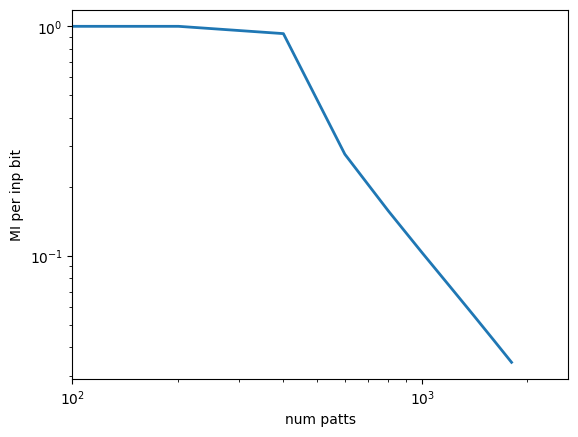

In [5]:
normlizd_l1 = err_sensl1
Npatts = np.array(nruns*[Npatts_lst])   # Npatts_lst repeated nruns times
Npatts = Npatts.T
print(Npatts.shape)

m = 1 - (2*normlizd_l1) 

a = (1+m)/2
b = (1-m)/2

print(a)
print(b)

a = torch.abs(torch.tensor(a))
b = torch.abs(torch.tensor(b))

S = - a * np.log2(a) - b * np.log2(b)
S = np.where(m==1, np.zeros_like(S), S)

MI = 1 - S
plt.errorbar(Npatts_lst,MI[0].mean(axis=1),yerr=MI[0].std(axis=1),lw=2); plt.xscale('log'); plt.yscale('log')
plt.xlim(xmin=100)
plt.ylabel('MI per inp bit')
plt.xlabel('num patts')
plt.show()